In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import sys
import torch

sys.path.append("../")
from environments.sac_tracking_env import Environment
from models import ResNet, ResidualBlock, ConvNet
from solvers import sac

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

## Instantiate environment

In [3]:
config_file = "../configs/sac_inference_simulated.json"
with open(config_file) as f:
    params = json.load(f)

img_path = params["img_path"]
outdir = params["outdir"]
name = params["name"]
step_size = params["step_size"] if "step_size" in params else 1.0
step_width = params["step_width"] if "step_width" in params else 1.0
alpha = params["alpha"] if "alpha" in params else 1.0
beta = params["beta"] if "beta" in params else 1e-3
friction = params["friction"] if "friction" in params else 1e-4
patch_radius = 17

if "classifier_weights" in params:
    classifier_path = params["classifier_weights"]
    classifier_state_dict = torch.load(classifier_path, weights_only=True)
    classifier = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=1)
    classifier = classifier.to(device=DEVICE, dtype=dtype)
    classifier.load_state_dict(classifier_state_dict)
    classifier.eval()
else:
    classifier = None

env = Environment(img_path,
                radius=patch_radius,
                step_size=step_size,
                step_width=step_width,
                max_len=10000,
                alpha=alpha,
                beta=beta,
                friction=friction,
                classifier=classifier)

## Instantiate actor network

In [4]:
in_channels = 4
actor = ConvNet(chin=in_channels, chout=4)
actor = actor.to(device=DEVICE,dtype=dtype)
if "sac_weights" in params:
    sac_weights_path = params["sac_weights"]
    sac_state_dicts = torch.load(sac_weights_path, weights_only=True)

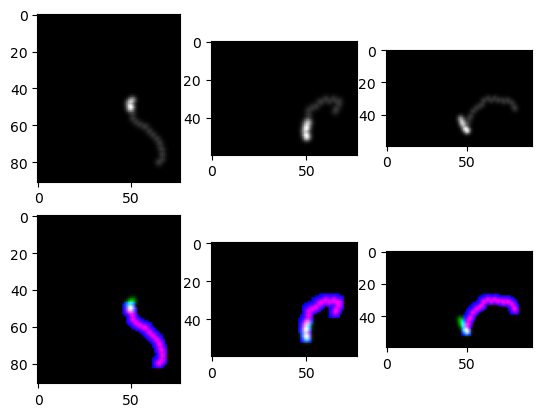

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

num branches: 1


<Figure size 640x480 with 0 Axes>

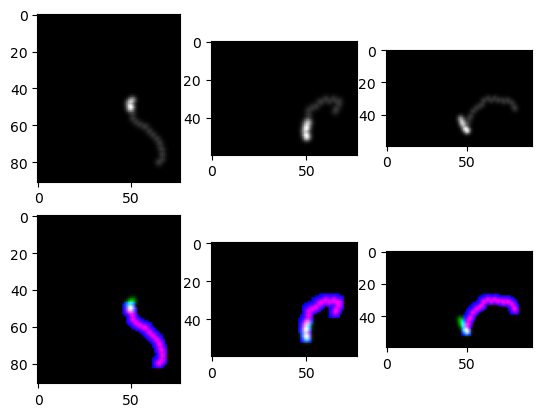

In [6]:
sac.inference(env, actor, outdir)